In [1]:
import os
import pathlib
import numpy as np
from numpy.random import randint, randn

from tqdm import tqdm
import cv2
from sklearn.utils import shuffle  

from matplotlib import pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, LeakyReLU, BatchNormalization, Activation, Dropout, MaxPool2D, Flatten, Dense
from keras.layers import Conv2DTranspose, Reshape, GaussianNoise

from keras import optimizers as o
from keras import regularizers as r

from keras.utils.vis_utils import plot_model
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator

# Import the data (IMAGE_SIZE = (128, 128))

In [2]:
! mkdir ~/.kaggle # create the .kaggle folder in the root directory
! echo '{"username":"panagiotis427","key":"ba4ea9629536514c923394e01146f747"}' > ~/.kaggle/kaggle.json # write kaggle API credentials to kaggle.json
! chmod 600 ~/.kaggle/kaggle.json  # set permissions
! pip install kaggle # install the kaggle library

In [3]:
! kaggle datasets download -d puneet6060/intel-image-classification -p /content/kaggle/

 98% 340M/346M [00:02<00:00, 188MB/s]
100% 346M/346M [00:02<00:00, 158MB/s]


In [4]:
%cd kaggle
! unzip intel-image-classification

Η έξοδος ροής περικόπηκε στις τελευταίες 5000 γραμμές.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/769

In [5]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
train_dir = "seg_train/seg_train/"
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [6]:
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (128, 128)

In [7]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    
    datasets = ['seg_train/seg_train', 'seg_test/seg_test']
    output = []
    train_mode = True

    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        if train_mode:
          images, labels = shuffle(images, labels, random_state=25)
          train_mode = False
        
        images = (images- 127.5) / 127.5
        
        output.append((images, labels))

    return output

In [8]:
(x_train, y_train), (x_test, y_test) = load_data()

Loading seg_train/seg_train


100%|██████████| 2271/2271 [00:01<00:00, 1175.74it/s]


Loading seg_test/seg_test


100%|██████████| 474/474 [00:00<00:00, 1211.76it/s]


# Discriminator

In [9]:
# Build the model
discriminator = Sequential([
  Conv2D(32, 3, input_shape=(128, 128, 3), padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  MaxPool2D(pool_size=2, strides=2),
  Dropout(0.3),

  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  MaxPool2D(pool_size=2, strides=2),
  Dropout(0.3),

  Conv2D(128, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  MaxPool2D(pool_size=2, strides=2),
  Dropout(0.3),

  Flatten(), # flatten

  Dense(128),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  Dropout(0.3),

  Dense(64),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  Dropout(0.3),  

  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1

In [10]:
# Onehot encoding
y_train = np_utils.to_categorical(y_train, 6)
y_test = np_utils.to_categorical(y_test, 6)

# Compilation
discriminator.compile(loss='categorical_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009, decay=1e-6),
                      metrics=['accuracy'])

# Evaluation
discriminator.fit(x_train, y_train, epochs=26, shuffle=True, 
                  validation_data=(x_test, y_test), batch_size=128)

Epoch 1/26
110/110 [==============================] - 35s 209ms/step - loss: 1.0026 - accuracy: 0.6419 - val_loss: 4.9952 - val_accuracy: 0.2820
Epoch 2/26
110/110 [==============================] - 22s 200ms/step - loss: 0.6752 - accuracy: 0.7570 - val_loss: 4.0073 - val_accuracy: 0.4067
Epoch 3/26
110/110 [==============================] - 21s 189ms/step - loss: 0.5777 - accuracy: 0.7928 - val_loss: 3.1092 - val_accuracy: 0.5370
Epoch 4/26
110/110 [==============================] - 21s 190ms/step - loss: 0.5273 - accuracy: 0.8122 - val_loss: 1.8650 - val_accuracy: 0.5830
Epoch 5/26
110/110 [==============================] - 21s 189ms/step - loss: 0.4689 - accuracy: 0.8370 - val_loss: 1.3263 - val_accuracy: 0.6407
Epoch 6/26
110/110 [==============================] - 21s 191ms/step - loss: 0.4217 - accuracy: 0.8522 - val_loss: 0.8071 - val_accuracy: 0.7487
Epoch 7/26
110/110 [==============================] - 21s 189ms/step - loss: 0.3790 - accuracy: 0.8626 - val_loss: 0.6658 - val_ac

# Generator

In [11]:
# define the number of nodes and latent dimension in the Input layer
n_nodes = 256 * 8 * 8
latent_dim = 100

generator = Sequential([
  Dense(n_nodes, input_dim = latent_dim),
  LeakyReLU(alpha=0.2),
  Reshape((8,8,256)),

  # upsample to 16x16
  Conv2DTranspose(512,(4,4),strides=(2,2),padding="same"),  
  LeakyReLU(alpha=0.2),

  # upsample to 32x32
  Conv2DTranspose(768,(4,4),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),

  # upsample to 64x64
  Conv2DTranspose(1024,(4,4),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),

  # upsample to 128x128
  Conv2DTranspose(2048,(4,4),strides=(2,2),padding="same"),
  LeakyReLU(alpha=0.2),

  # output
  Dense(3, activation='tanh'),
  Reshape((128, 128, 3))
])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16384)             1654784   
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 512)      2097664   
 nspose)                                                         
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 16, 16, 512)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 768)      6292224   
 ranspose)                                            

In [12]:
# Compilation
generator.compile(loss='mean_squared_error', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009, decay=1e-6),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Building GAN

In [13]:
discriminator.trainable = False

gan = Sequential()
gan.add(generator)
gan.add(discriminator)

gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       56191235  
                                                                 
 sequential (Sequential)     (None, 6)                 4297990   
                                                                 
Total params: 60,489,225
Trainable params: 56,191,235
Non-trainable params: 4,297,990
_________________________________________________________________


In [14]:
gan.compile(loss='categorical_crossentropy', 
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009, decay=1e-6),
            metrics='accuracy')

In [15]:
def generate_latent_points(latent_dim):
  x = randn(latent_dim)
  x = x.reshape(1,latent_dim)
  return x

In [25]:
classes = np.array([0, 1, 2, 3, 4, 5])
generated_images = []

images = x_train[20:21]
for image in images:
  for target in classes:
    if target != np.argmax(y_train[20]):
      target_class = np.zeros((1,6))
      target_class[0][target] = 1
      latent_points = generate_latent_points(latent_dim)
      for _ in tqdm(range(100)):
        generator.train_on_batch(latent_points, image.reshape(1,128,128,3))
        gan.train_on_batch(latent_points, target_class)
      generated_images.append(generator.predict(latent_points))

100%|██████████| 100/100 [02:23<00:00,  1.43s/it]


# Results

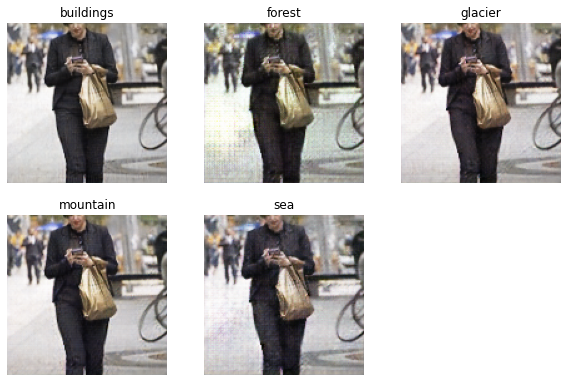

In [26]:
plt.figure(figsize=(10,10))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, len(classes)/2, i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape((128,128,3)))
  plt.title(class_names[np.argmax(discriminator.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()

# Deeper Discriminator

In [18]:
# Build the model
discriminator_2A = Sequential([
  Conv2D(32, 3, input_shape=(128, 128, 3), padding='same'),
  LeakyReLU(alpha=0.2),
  GaussianNoise(0.4),

  Conv2D(32, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  MaxPool2D(pool_size=2, strides=2),
  Dropout(0.3),
  GaussianNoise(0.4),

  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  GaussianNoise(0.4),

  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  MaxPool2D(pool_size=2, strides=2),
  Dropout(0.3),
  GaussianNoise(0.4),

  Conv2D(128, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  GaussianNoise(0.4),

  Conv2D(64, 3, padding='same'),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  MaxPool2D(pool_size=2, strides=2),
  Dropout(0.3),
  GaussianNoise(0.4),

  Flatten(), # flatten

  Dense(128),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  Dropout(0.3),
  GaussianNoise(0.4),

  Dense(96),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  Dropout(0.3),
  GaussianNoise(0.4),

  Dense(64),
  LeakyReLU(alpha=0.2),
  BatchNormalization(),
  Dropout(0.3),
  GaussianNoise(0.4),  

  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

discriminator_2A.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 128, 128, 32)     0         
 se)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 batch_normalization_5 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                      

In [21]:
adaptive_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

# Compilation
discriminator_2A.compile(loss='categorical_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0009, decay=1e-6),
                      metrics=['accuracy'])

# Evaluation
discriminator_2A.fit_generator(datagen.flow(x_train, y_train, batch_size=64),
                            epochs=26, shuffle=True, callbacks=[adaptive_lr],
                            verbose=1, validation_data=(x_test,y_test))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/26
220/220 [==============================] - 82s 346ms/step - loss: 1.5214 - accuracy: 0.4480 - val_loss: 2.4071 - val_accuracy: 0.2823 - lr: 9.0000e-04
Epoch 2/26
220/220 [==============================] - 74s 335ms/step - loss: 1.1249 - accuracy: 0.5647 - val_loss: 2.1053 - val_accuracy: 0.3500 - lr: 9.0000e-04
Epoch 3/26
220/220 [==============================] - 72s 329ms/step - loss: 0.9960 - accuracy: 0.6129 - val_loss: 1.6185 - val_accuracy: 0.4850 - lr: 9.0000e-04
Epoch 4/26
220/220 [==============================] - 74s 335ms/step - loss: 0.9170 - accuracy: 0.6520 - val_loss: 1.1204 - val_accuracy: 0.5963 - lr: 9.0000e-04
Epoch 5/26
220/220 [==============================] - 73s 333ms/step - loss: 0.8579 - accuracy: 0.6771 - val_loss: 1.3617 - val_accuracy: 0.5683 - lr: 9.0000e-04
Epoch 6/26
220/220 [==============================] - 73s 329ms/step - loss: 0.8042 - accuracy: 0.7004 - val_loss: 1.5425 - val_accuracy: 0.5903 - lr: 9.0000e-04
Epoch 7/26
220/220 [========

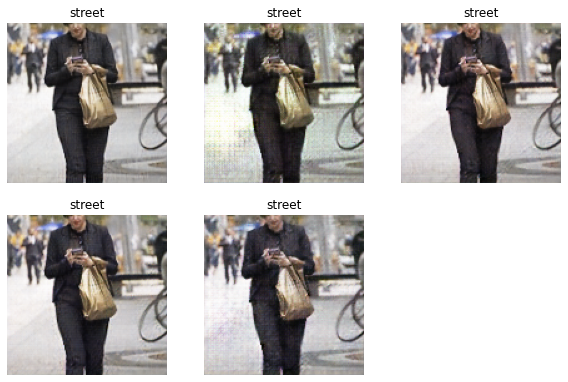

In [27]:
plt.figure(figsize=(10,10))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, len(classes)/2, i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape((128,128,3)))
  plt.title(class_names[np.argmax(discriminator_2A.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()

# My best discriminator

In [28]:
# Build the model
discriminator_2B = Sequential([
  Conv2D(16, 3, input_shape=(128, 128, 3), padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(32, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(64, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Conv2D(128, 3, padding='same'),
  BatchNormalization(),
  Activation('relu'),
  Dropout(0.1),
  MaxPool2D(),
  Flatten(), # flatten
  Dense(240),
  Activation('relu'),
  Dropout(0.1),
  Dense(120),
  Activation('relu'),
  Dropout(0.1),
  Dense(24),
  Activation('relu'),
  Dropout(0.1),
  Dense(6), # number of neurons same as number of classes
  Activation('softmax')
])

discriminator_2B.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 128, 16)     64        
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 128, 128, 16)      0         
                                                                 
 dropout_11 (Dropout)        (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)       

In [29]:
adaptive_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.00001)

#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

# Compilation
discriminator_2B.compile(loss='categorical_crossentropy', 
                      optimizer=tf.keras.optimizers.Adam(lr=0.0009, decay=1e-6),
                      metrics=['accuracy'])

# Evaluation
discriminator_2B.fit_generator(datagen.flow(x_train, y_train, batch_size=64),
                            epochs=18, shuffle=True, callbacks=[adaptive_lr],
                            verbose=1, validation_data=(x_test,y_test))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/18
220/220 [==============================] - 61s 269ms/step - loss: 1.3576 - accuracy: 0.4775 - val_loss: 1.7035 - val_accuracy: 0.2643 - lr: 9.0000e-04
Epoch 2/18
220/220 [==============================] - 59s 269ms/step - loss: 0.9352 - accuracy: 0.6449 - val_loss: 1.0020 - val_accuracy: 0.6007 - lr: 9.0000e-04
Epoch 3/18
220/220 [==============================] - 60s 272ms/step - loss: 0.7913 - accuracy: 0.7180 - val_loss: 0.6169 - val_accuracy: 0.7830 - lr: 9.0000e-04
Epoch 4/18
220/220 [==============================] - 60s 274ms/step - loss: 0.7029 - accuracy: 0.7580 - val_loss: 0.8077 - val_accuracy: 0.7103 - lr: 9.0000e-04
Epoch 5/18
220/220 [==============================] - 60s 274ms/step - loss: 0.6504 - accuracy: 0.7726 - val_loss: 0.7719 - val_accuracy: 0.7153 - lr: 9.0000e-04
Epoch 6/18
220/220 [==============================] - 61s 278ms/step - loss: 0.5397 - accuracy: 0.8158 - val_loss: 0.5799 - val_accuracy: 0.7927 - lr: 1.8000e-04
Epoch 7/18
220/220 [========

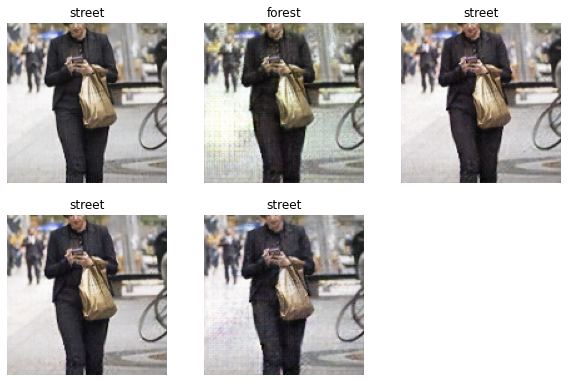

In [30]:
plt.figure(figsize=(10,10))
for i in range(len(generated_images)):
  plt.subplot(len(images)*3, len(classes)/2, i+1)
  plt.axis('off')
  plt.imshow(((generated_images[i]+1)/2).reshape((128,128,3)))
  plt.title(class_names[np.argmax(discriminator_2B.predict(generated_images[i]))])
# save plot to file
filename = 'generated_images.png' 
plt.savefig(filename)
plt.show()